In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
path = r"C:\data\benchmarks"
path = r"/home/perdelt/benchmarks"

In [3]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties


def get_performance(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Goodput (requests/second)': 'sum',
        'Latency Distribution.Average Latency (microseconds)': 'mean'
    }).reset_index()
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            """
            print(c['name'], 
                  c['timeLoad'], 
                  '[s] for', 
                  c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'], 
                  'threads on',
                  c['hostsystem']['node'])
            """
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
        }).reset_index()
        return result


# Container

In [4]:
codes = [
    # container
    '1750720553', #tenants=5
    '1750726431', #tenants 6
    
    # database
    '1750718667', #tenants=5
    '1750724506', #tenants=5
    
    #schema
    '1750716774', #tenants=5
    '1750722558', #tenants=5    
]

In [5]:
df_performance = get_performance_all(codes)
df_performance

,client,Goodput (requests/second),Latency Distribution.Average Latency (microseconds),type,num_tenants
0,1,7036.374318,70179.000000,container,5
1,2,9924.644833,49610.800000,container,5
0,1,7601.512828,77875.166667,container,6
1,2,10213.015541,57847.833333,container,6
0,1,2682.711557,185119.800000,database,5
1,2,3890.644820,127271.000000,database,5
0,1,2836.034754,210141.666667,database,6
1,2,3725.953174,159425.833333,database,6
0,1,2479.501489,200247.600000,schema,5
1,2,3801.674652,130419.200000,schema,5


9
9
[<matplotlib.patches.Rectangle object at 0x7ee9041dee90>, <matplotlib.patches.Rectangle object at 0x7ee90410f650>, <matplotlib.patches.Rectangle object at 0x7ee9041dc350>, <matplotlib.patches.Rectangle object at 0x7ee90456d010>, <matplotlib.patches.Rectangle object at 0x7ee90411fed0>, <matplotlib.patches.Rectangle object at 0x7ee904198dd0>, <matplotlib.patches.Rectangle object at 0x7ee8ffd66c10>, <matplotlib.patches.Rectangle object at 0x7ee9041ea210>, <matplotlib.patches.Rectangle object at 0x7ee9042ca090>]
Visible bar 0: height=7036.374318299121, x=-0.2666666666666667
Visible bar 1: height=2682.711557093211, x=0.0
Visible bar 2: height=2479.5014891881506, x=0.2666666666666666
Visible bar 3: height=7601.512828189973, x=0.7333333333333333
Visible bar 4: height=2836.0347543866924, x=1.0
Visible bar 5: height=2624.413174215911, x=1.2666666666666666
(5, 'container')
Rectangle(xy=(-0.4, 0), width=0.266667, height=7036.37, angle=0)
(5, 'database')
Rectangle(xy=(-0.133333, 0), width=0.26

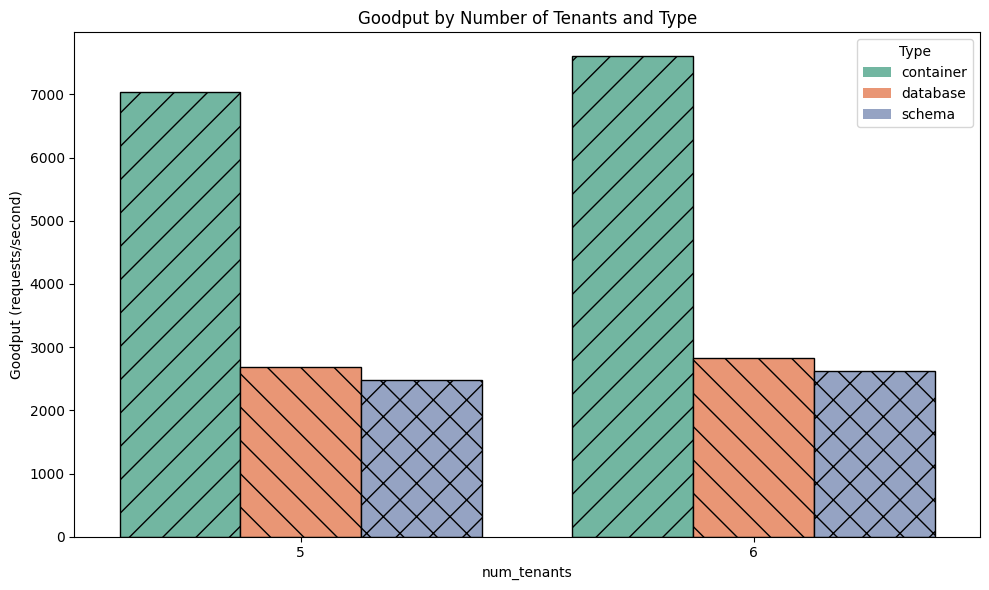

Visible bar 0: height=7036.374318299121, x=-0.2666666666666667
Visible bar 1: height=7601.512828189973, x=0.7333333333333333
Visible bar 2: height=2682.711557093211, x=0.0
Visible bar 3: height=2836.0347543866924, x=1.0
Visible bar 4: height=2479.5014891881506, x=0.2666666666666666
Visible bar 5: height=2624.413174215911, x=1.2666666666666666


In [50]:
df_plot = df_performance.copy()
df_plot = df_plot[df_plot['client']=='1']
df_plot = df_plot.sort_values(['num_tenants','type'])

# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}

hue_order = ['container', 'database', 'schema']

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_plot,
    x='num_tenants',
    y='Goodput (requests/second)',
    hue='type',
    estimator='min',
    palette='Set2',
    hue_order=hue_order
)


# Get tick positions (i.e., the x-axis categories)
xticks = ax.get_xticks()
bar_width = ax.patches[0].get_width()

# Create a mapping from (num_tenants, type) to hatch
grouped = df_plot.groupby(['num_tenants', 'type']).agg({'Goodput (requests/second)': 'min'}).reset_index()
#print(grouped)
#print(grouped_sorted)
grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}

#print(grouped_dict)

print(len(ax.patches))
bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)

print(len(bars))

print(bars)
for i, bar in enumerate(bars):
    if bar.get_height() > 0:
        print(f"Visible bar {i}: height={bar.get_height()}, x={bar.get_x() + bar.get_width()/2}")

# Assign the ID to each bar
for bar, (_, row) in zip(bars, grouped.iterrows()):
    bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
    print(bar.my_id)
    #print(grouped_dict[(bar.my_id)])
    #print(hatch_map[row['type']])
    #if row['type'] == 'container':
    bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
    bar.set_edgecolor('black')
    bar.set_linewidth(1)
    print(bar)


# Final touches
plt.legend(title='Type')
plt.title("Goodput by Number of Tenants and Type")
plt.tight_layout()
plt.show()

for i, bar in enumerate(ax.patches):
    if bar.get_height() > 0:
        print(f"Visible bar {i}: height={bar.get_height()}, x={bar.get_x() + bar.get_width()/2}")


In [7]:
get_loading_time_max(evaluation)

df_performance = pd.DataFrame()
for code in codes:
    evaluation = evaluators.benchbase(code=code, path=path)
    workload = get_workload(code)
    df = get_loading_time_max(evaluation)
    df['type']=workload['tenant_per']
    df['num_tenants']=workload['num_tenants']
    #print(df)
    df_performance = pd.concat([df_performance, df])

df_performance#.plot.bar(y=['time_load'])

NameError: name 'evaluation' is not defined

In [ ]:
df_plot = df_performance.copy()
df_plot = df_plot[df_plot['client']=='1']
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='num_tenants', y='time_check', hue='type', palette='Set2', estimator=max)

plt.title('Time Load by Client Colored by Type')
plt.xlabel('num_tenants')
plt.ylabel('Time Load')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

In [ ]:
get_monitoring_stream(evaluation)

get_loading_time_max(evaluation)

df_performance = pd.DataFrame()
for code in codes:
    evaluation = evaluators.benchbase(code=code, path=path)
    workload = get_workload(code)
    df = get_monitoring_stream(evaluation)
    df['type']=workload['tenant_per']
    df['num_tenants']=workload['num_tenants']
    #print(df)
    df_performance = pd.concat([df_performance, df])

df_performance.sort_values('num_tenants')

# Database

In [ ]:
code = '1750685768'
evaluation = evaluators.benchbase(code=code, path=path)

In [ ]:
get_performance(evaluation)

In [ ]:
get_loading_time_max(evaluation)

In [ ]:
get_monitoring_stream(evaluation)

# Schema

In [ ]:
code = '1750685007'
evaluation = evaluators.benchbase(code=code, path=path)
workload = get_workload(code)

In [ ]:
df=get_performance(evaluation)
df['type']=workload['tenant_per']
df['num_tenants']=workload['num_tenants']
df

In [ ]:
get_loading_time_max(evaluation)

In [ ]:
get_monitoring_stream(evaluation)